# WAMECU Milestone 3 – Adaptive $\beta$ Estimator

This notebook simulates drifting bias coefficients and demonstrates an online estimator that adapts in real time. The experiment follows these steps:

1. Generate a synthetic drift for $\beta_t$ across multiple outcomes.
2. Draw streaming observations from the evolving categorical distribution.
3. Track the latent bias coefficients with an exponentially weighted estimator.
4. Visualize true vs. estimated $\beta$ trajectories.


In [1]:
import sys, pathlib
CURRENT_DIR = pathlib.Path().resolve()
for candidate in [CURRENT_DIR, *CURRENT_DIR.parents[:3]]:
    src_path = candidate / 'src'
    if src_path.exists():
        sys.path.append(str(src_path))
        break


## Imports and configuration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wamecu import AdaptiveBetaEstimator, simulate_beta_drift, simulate_time_varying_draws, wamecu_probabilities

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)


## Simulate drifting bias coefficients

In [3]:
N_OUTCOMES = 6
N_STEPS = 300
DRIFT_SCALE = 0.04

beta_series = simulate_beta_drift(
    n_outcomes=N_OUTCOMES,
    n_steps=N_STEPS,
    drift='sinusoidal',
    scale=DRIFT_SCALE,
    seed=123,
)

beta_df = pd.DataFrame(beta_series, columns=[f'Outcome {i}' for i in range(N_OUTCOMES)])
beta_df.insert(0, 'step', np.arange(N_STEPS))

beta_df.head()


,step,Outcome 0,Outcome 1,Outcome 2,Outcome 3,Outcome 4,Outcome 5
0,0,-0.018563,0.037950,-0.040966,-0.019347,0.002411,0.038515
1,1,-0.017519,0.037697,-0.040810,-0.019074,0.001368,0.038339
2,2,-0.016462,0.037439,-0.040644,-0.018797,0.000325,0.038139
3,3,-0.015390,0.037176,-0.040468,-0.018514,-0.000718,0.037914
4,4,-0.014306,0.036909,-0.040282,-0.018227,-0.001759,0.037666


## Stream draws from the evolving distribution

In [4]:
probability_series = np.vstack([
    wamecu_probabilities(N_OUTCOMES, beta) for beta in beta_series
])

draws = simulate_time_varying_draws(beta_series, seed=2024)

stream_df = pd.DataFrame(
    {
        'step': np.arange(N_STEPS),
        'draw': draws,
    }
)

stream_df.head()


,step,draw
0,0,4
1,1,1
2,2,1
3,3,4
4,4,5


## Adaptive estimation of $\beta_t$

In [5]:
estimator = AdaptiveBetaEstimator(n_outcomes=N_OUTCOMES, smoothing=0.05)
estimated_beta = estimator.batch_update(draws)

estimate_df = pd.DataFrame(estimated_beta, columns=[f'Outcome {i}' for i in range(N_OUTCOMES)])
estimate_df.insert(0, 'step', np.arange(N_STEPS))

estimate_df.head()


,step,Outcome 0,Outcome 1,Outcome 2,Outcome 3,Outcome 4,Outcome 5
0,0,-0.050000,-0.050000,-0.050000,-0.050000,0.250000,-0.050000
1,1,-0.097500,0.202500,-0.097500,-0.097500,0.187500,-0.097500
2,2,-0.142625,0.442375,-0.142625,-0.142625,0.128125,-0.142625
3,3,-0.185494,0.370256,-0.185494,-0.185494,0.371719,-0.185494
4,4,-0.226219,0.301743,-0.226219,-0.226219,0.303133,0.073781


## Compare true vs. estimated bias coefficients

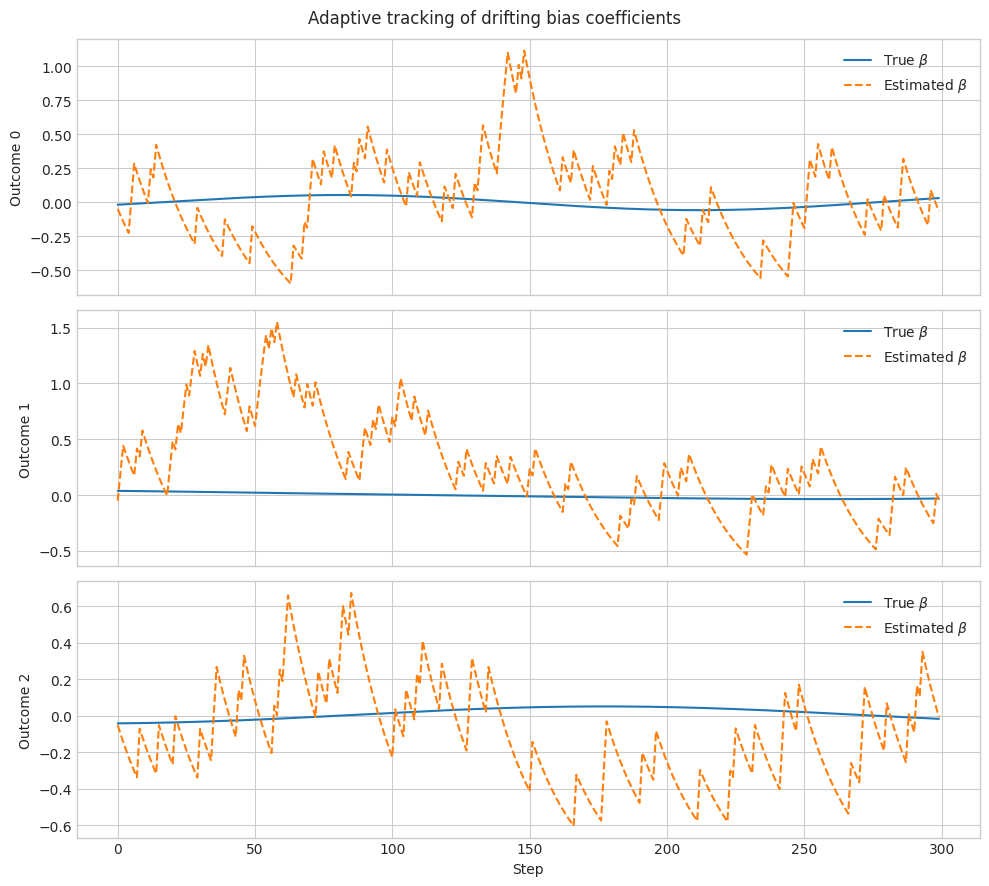

In [6]:
OUTCOMES_TO_PLOT = [0, 1, 2]
fig, axes = plt.subplots(len(OUTCOMES_TO_PLOT), 1, figsize=(10, 9), sharex=True)

for ax, idx in zip(axes, OUTCOMES_TO_PLOT):
    ax.plot(beta_df['step'], beta_df[f'Outcome {idx}'], label=r'True $\beta$')
    ax.plot(estimate_df['step'], estimate_df[f'Outcome {idx}'], label=r'Estimated $\beta$', linestyle='--')
    ax.set_ylabel(f'Outcome {idx}')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Step')
fig.suptitle('Adaptive tracking of drifting bias coefficients')
plt.tight_layout()
plt.show()


The estimator smoothly follows the latent drift with a short lag determined by the smoothing factor. This completes Milestone 3 for the adaptive $\beta$ tracker.